#### **Corrective RAG with Langgraph**

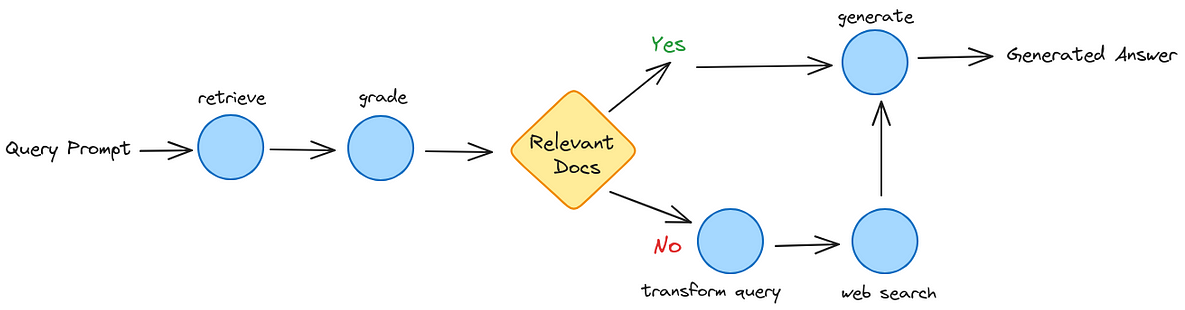

**Corrective RAG** refers to the extension or enhancement of the **basic RAG** methodology, where the retrieved information is actively corrected or refined before it is passed to the generation step. This correction process can take place in several ways to improve the final response's accuracy, relevance, and clarity.

**Steps in Corrective RAG:**
1. **Query Understanding:** The model analyzes the input query and retrieves relevant documents or information from a large knowledge base.

2. **Document Correction:** A secondary model or mechanism refines the retrieved content. This could involve:

    - **Fact-Checking:** Verifying the accuracy of the retrieved information.
    - **Refinement:** Enhancing the coherence, clarity, or relevance of the retrieved documents.
    - **Disambiguation:** Resolving any ambiguity in the retrieved information (e.g., differentiating between similarly named entities).

4. **Integration of Corrected Information:** The corrected or refined retrieved documents are then fed into a generative model to produce the final output.

5. **Output Generation:** The generative model uses both the input query and the corrected content to generate an accurate, contextually relevant, and factually correct response.


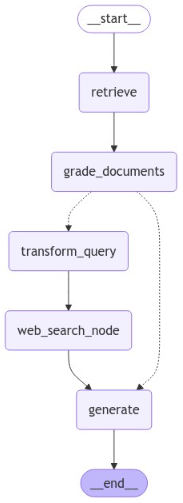

In [1]:
# Importing the required libraries & packages
import os
import numpy as np
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_groq import ChatGroq
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel,Field
from langchain import hub
from typing import List
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langgraph.graph import MessagesState,Graph,START,END,StateGraph
from langchain.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
load_dotenv()

USER_AGENT environment variable not set, consider setting it to identify your requests.


True

In [2]:
# Loading the environment variables and setting them
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [3]:
# Loading the LLM model from the groq
llm = ChatGroq(model_name="Gemma2-9b-It",temperature=0)

In [4]:
# Loading the embedding model from google
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [5]:
# Loading the data from the urls
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
 
docs = []
for url in urls:
    loader = WebBaseLoader(url)
    docs.extend(loader.load())

In [6]:
# Store the chunks created using text splitter in vector database
text_splitter = RecursiveCharacterTextSplitter(chunk_size=250,chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs)

vectorstore = Chroma.from_documents(documents=doc_splits,collection_name="rag-chroma",embedding=embeddings)
retriever = vectorstore.as_retriever()

In [7]:
# Lets create a RAG chain now
prompt = hub.pull("rlm/rag-prompt")

rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

question = "tell me about agent memory"
retrieved_docs = retriever.get_relevant_documents(question)
result = rag_chain.invoke({"context":retrieved_docs,"question":question})
print(result)

c:\Users\admin\anaconda3\envs\env_phidata_agents\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
C:\Users\admin\AppData\Local\Temp\ipykernel_18852\3131533754.py:11: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(question)


Agent memory is crucial for autonomous agents powered by LLMs.  It allows the agent to retain and recall information over extended periods, enabling it to learn from past experiences and make informed decisions.  Long-term memory often utilizes an external vector store for efficient storage and retrieval. 



In [8]:
# Lets create the grade document class and grader_chain
class GradeDocument(BaseModel):
    """Binary score represents, relevance score for retrieved documents"""
    binary_score:str = Field(description="Documents are relevant to the question, 'yes' or 'no'")
    
graded_structured_llm = ChatGroq(model_name="Gemma2-9b-It",temperature=0).with_structured_output(GradeDocument)

system = """
You are a grader assessing relevance of a retrieved document to a user question. \n 
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""

grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","Retrieved document: \n\n {document} \n\n User question : {question}")
    ]
)
grader_chain = (
    grader_prompt
    | graded_structured_llm
)

In [9]:
docs[1].page_content

'\n\n\n\n\n\nPrompt Engineering | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      Prompt Engineering\n    \nDate: March 15, 2023  |  Estimated Reading Time: 21 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBasic Prompting\n\nZero-Shot\n\nFew-shot\n\nTips for Example Selection\n\nTips for Example Ordering\n\n\n\nInstruction Prompting\n\nSelf-Consistency Sampling\n\nChain-of-Thought (CoT)\n\nTypes of CoT prompts\n\nTips and Extensions\n\n\nAutomatic Prompt Design\n\nAugmented Language Models\n\nRetrieval\n\nProgramming Language\n\nExternal APIs\n\n\nCitation\n\nUseful Resources\n\nReferences\n\n\n\n\n\nPrompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without u

In [10]:
question = "What is agent memory ?"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(grader_chain.invoke({"document":doc_txt,"question":question}))

binary_score='yes'


In [11]:
question = "What is Love, tell me about TajMahal ?"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(grader_chain.invoke({"document":doc_txt,"question":question}))

binary_score='no'


In [12]:
# Question rewritter chain
class RewriteQuery(BaseModel):
    """Rewrite the question in consise and clear format"""
    question:str = Field(description="Rewritten question asked by user, into consie format")
    
system = """
You are a question rewriter who enhances input queries for optimal web search.
Analyze the input, infer its underlying intent, and rephrase it for clarity, relevance, and search efficiency.
Respond in a structured JSON format following the given schema.
"""

rewritter_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","Rewrite the following question properly : {question}")
    ]
)
rewritter_strcuture_llm = ChatGroq(model_name="Gemma2-9b-It",temperature=0).with_structured_output(RewriteQuery)
rewritter_chain = (rewritter_prompt | rewritter_strcuture_llm)

In [13]:
rewritter_chain.invoke({"question":"What is the is tajmahal explain me is the taj mahal ?"}).question

'What is the Taj Mahal? Explain it to me.'

rag_chain --> grader_chain --> rewritter_chain 

Now **grader_chain** requires document and question as input, so we have to pass this to grader chain in the form of state.

In [14]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        {"documents": documents, "question": question}
    """
    print("----- RETRIEVE -----")
    question = state["question"]
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

In [15]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("----- CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT -----")
    question = state["question"]
    documents = state["documents"]
    
    filtered_docs = []
    web_search = 'no'
    
    for d in documents:
        score = grader_chain.invoke({"document":d.page_content,"question":question})
        grade = score.binary_score
        if grade == "yes":
            print("----- GRADE : DOCUMENT RELEVANCE -----")
            filtered_docs.append(d)
        else:
            print("----- GRADE : DOCUMENT NOT RELEVANT -----")
            web_search = "yes"
            continue
    return {"documents":filtered_docs,"question":question,"web_search":web_search}

In [16]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation : contains LLM generated output
    """
    print("----- GENERATE -----")
    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"context":documents,"question":question})
    return {"documents":documents,"question":question,"generation":generation}

In [17]:
def transform_query(state):
    """ 
    Transform the query to produce a better question.

        Args:
            state (dict): The current graph state

        Returns:
            state (dict): Updates question key with a re-phrased question
    """
    print("----- TRANSFORM QUERY -----")
    question = state["question"]
    documents = state["documents"]
    better_question = rewritter_chain.invoke({"question":question})
    return {"documents":documents,"question":better_question.question}

In [18]:
web_search_tool = TavilySearchResults(k=3)

In [27]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("----- WEB SEARCH -----")
    question = state["question"]
    documents = state["documents"]
    print("from graded chain :",documents)
    docs = web_search_tool.invoke({"query":question})
    web_results = "\n".join(d['content'] for d in docs)
    web_document = Document(page_content=web_results)
    documents.append(web_document)
    print(documents)
    return {"documents": documents, "question": question}

In [28]:
def Isgenerate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("----- ASSESS GRADED DOCUMENTS -----")
    state["question"]
    web_search = state["web_search"]
    state["documents"]
    
    if web_search.lower() == "yes":
        print("----- DECISION : ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY -----")
        return "transform_query"
    else:
        print("----- DECISION : GENERATE -----")
        return "generate"

In [29]:
# Define the state of message
class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question:str
    generation:str
    web_search:str
    documents:List[str]

In [30]:
# Generate the workflow
workflow = StateGraph(State)

workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges("grade_documents", Isgenerate, {"transform_query": "transform_query","generate": "generate",}),
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()

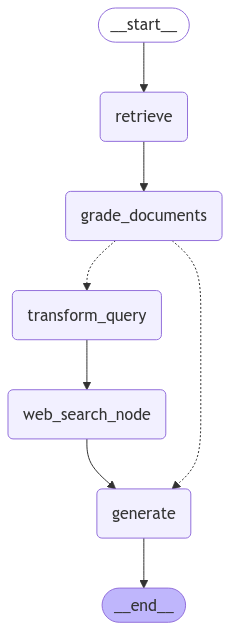

In [31]:
app

In [32]:
from pprint import pprint
inputs = {"question":"WHat is the tajmahal who built it ?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
# Final generation
pprint(value["generation"])

----- RETRIEVE -----
"Node 'retrieve':"
----- CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT -----
----- GRADE : DOCUMENT NOT RELEVANT -----
----- GRADE : DOCUMENT RELEVANCE -----
----- GRADE : DOCUMENT RELEVANCE -----
----- GRADE : DOCUMENT RELEVANCE -----
----- ASSESS GRADED DOCUMENTS -----
----- DECISION : ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY -----
"Node 'grade_documents':"
----- TRANSFORM QUERY -----
"Node 'transform_query':"
----- WEB SEARCH -----
from graded chain : [Document(id='2f585b75-a48d-4272-a96c-99c467e5f658', metadata={'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.\nA large body of ground wor

In [33]:
inputs = {"question":"tell is the me about the agent memories."}


In [34]:
# this will only return the updated state
app.invoke(inputs)

----- RETRIEVE -----
----- CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT -----
----- GRADE : DOCUMENT RELEVANCE -----
----- GRADE : DOCUMENT NOT RELEVANT -----
----- GRADE : DOCUMENT RELEVANCE -----
----- GRADE : DOCUMENT RELEVANCE -----
----- ASSESS GRADED DOCUMENTS -----
----- DECISION : ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY -----
----- TRANSFORM QUERY -----
----- WEB SEARCH -----
from graded chain : [Document(id='895f4e68-d84a-4a49-b98a-cd0899f3126b', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key component

{'question': 'What are agent memories?',
 'generation': 'Agent memories are crucial for enabling agents to learn from past experiences and make informed decisions.  They come in different types, including short-term memory for immediate context and long-term memory for retaining information over extended periods.  Long-term memory often utilizes external vector stores for efficient storage and retrieval. \n',
 'web_search': 'yes',
 'documents': [Document(id='895f4e68-d84a-4a49-b98a-cd0899f3126b', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by sev